In [1]:
%matplotlib inline

from pathlib import Path
import re
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon
import scipy.stats as sstats
from scipy.optimize import curve_fit
import h5py

In [2]:
class RunInfo(namedtuple("_Run", ("subject", "session", "domain", "run", "suffix"))):
    """a class for managing the run info based on single file names."""
    
    PATTERN = re.compile(r"([a-zA-Z0-9-]+)_([0-9-]+)-([0-9a-zA-Z-]+)_([a-zA-Z0-9-]+)_run([0-9-]+)\.")
    @classmethod
    def from_path(cls, path):
        path = Path(path)
        matched = cls.PATTERN.match(path.name)
        if not matched:
            raise ValueError(f"does not match to the run pattern: {path.name}")
        patlen = len(matched.group(0)) - 1
        return cls(matched.group(1),
                   f"{matched.group(2)}-{matched.group(3)}",
                   matched.group(4),
                   matched.group(5),
                   path.name[patlen:])
    
    def update(self, **kv):
        args = dict((attr, getattr(self, attr)) for attr in self._fields)
        for k, v in kv.items():
            if k not in args.keys():
                print(f"***ignored: {k}={repr(v)}")
            else:
                args[k] = v
        return self.__class__(**args)
    
    @property
    def name(self):
        return f"{self.subject}_{self.session}_{self.domain}_run{self.run}{self.suffix}"

    def to_path(self, root=None):
        if root is None:
            root = Path()
        return root / self.subject / self.session / self.name

In [3]:
root_realtime = Path("../../RawVideos")
root_posthoc  = Path("../../PostHocEstimations")

# Single session

In [4]:
sub  = "SNA-079258"
sess = "2020-12-06-test"
run  = "131412"

In [5]:
path_posthoc  = sorted(p for p in (root_posthoc / sub / sess).glob(f"*_run{run}.h5"))[0]
info = RunInfo.from_path(path_posthoc)
path_realtime = info.update(domain="video").to_path(root=root_realtime)
assert(path_realtime.exists())

In [6]:
info

RunInfo(subject='SNA-079258', session='2020-12-06-test', domain='posthoc', run='131412', suffix='.h5')

Check the contents of the `realtime` video file.

In [7]:
realtime = h5py.File(str(path_realtime), "r")

In [8]:
[k for k in realtime.keys()]

['estimation', 'frames', 'process_end', 'timestamps', 'trigger_status']

In [9]:
[f"{k}={v}" for k, v in realtime.attrs.items()]

['evaluation={Tip2.x} < 320',
 'exposure_us=200',
 'frame_interval_mode=busy-wait',
 'gain=0',
 'height_px=480',
 'target_frame_interval_ms=10',
 'width_px=640']

In [10]:
realtime.close()

In [11]:
posthoc = h5py.File(str(path_posthoc), "r")

In [12]:
[k for k in posthoc.keys()]

['DeepLabCut', 'Tip1', 'Tip2', 'Tip3', 'session']

In [13]:
posthoc.close()

## Data retrieval

The x-coordinates and the evaluation expressions are to be retrieved, to be compared between the real-time and the post-hoc data.

In [14]:
def noop(coords):
    return np.empty(coords.Tip1.size, dtype=np.float64)*np.nan

def decompose_expression(expr):
    compiled = compile(expr, "<evaluation>", mode="eval")
    for op in (">=", "<=", ">", "<", "!=", "=="):
        if op not in expr:
            continue
        lhs, rhs = expr.split(op)
        cov_l = "coords" in lhs
        cov_r = "coords" in rhs
        if cov_l == True:
            if cov_r == True:
                raise ValueError("both lhs and rhs contain coordinate placeholders")
            placeholder = compile(lhs, "<placeholder>", mode="eval")
            constant    = eval(rhs)
            if ">" in op:
                sign = 1
            elif "<" in op:
                sign = -1
            else:
                sign = 0
        elif cov_r == True:
            placeholder = compile(rhs, "<placeholder>", mode="eval")
            constant    = eval(lhs)
            if ">" in op:
                sign = -1
            elif "<" in op:
                sign = 1
            else:
                sign = 0
        else:
            placeholder = noop
            constant    = np.nan
            sign        = 0
        return placeholder, constant, sign, compiled
            

class Evaluation(namedtuple("_Eval", ("expression",
                                      "placeholder",
                                      "constant",
                                      "sign",
                                      "compiled"))):
    """the representation of the expression to be evaluated.
    
    the references e.g. {Tip2.x} becomes replaced by `coords.Tip2`
    to be used with the Xcoords class.
    
    calling `Evaluation.compute_placeholder(xcoords)` returns the value of the placeholder part.
    calling `Evaluation.evaluate(xcoords)` returns the trigger (evaluation) status.
    
    expression -- the raw expression in string.
    placeholder -- the placeholder-part that changes from frame to frame, as a code object.
    constant    -- the constant part to be referenced, as a number.
    sign        -- the direction in which the value of the placeholder-part is more likely to be evaluated true.
    compiled    -- the Boolean evaluation as a code object.
    """
    @classmethod
    def from_hdf5(cls, path):
        with h5py.File(str(path), "r") as src:
            expr = src.attrs["evaluation"]
        for part in Xcoords._fields:
            expr = expr.replace(f"{{{part}.x}}", f"coords.{part}")
        return cls(expr, *(decompose_expression(expr)))

    def compute_placeholder(self, coords):
        return eval(self.placeholder, dict(coords=coords))
    
    def evaluate(self, coords):
        return eval(self.compiled, dict(coords=coords))

class Xcoords(namedtuple("_X", ("Tip1", "Tip2", "Tip3"))):
    """the x-coordinates of the tracked body parts during a session."""
    @classmethod
    def from_hdf5(cls, path):
        out = dict()
        with h5py.File(str(path), "r") as src:
            for part in cls._fields:
                if "estimation" in src.keys():
                    out[part] = np.array(src[f"estimation/{part}/x"])
                else:
                    out[part] = np.array(src[f"{part}/x"])
        return cls(**out)

def get_time(path):
    """read timestamps info from the video."""
    with h5py.File(str(path), "r") as src:
        t = np.array(src["timestamps"])
    return t - t.min()

def get_scale(path_posthoc):
    with h5py.File(str(path_posthoc), "r") as src:
        return src["session"].attrs["px_per_mm"]

In [15]:
x = Xcoords.from_hdf5(path_realtime)
e = Evaluation.from_hdf5(path_realtime)

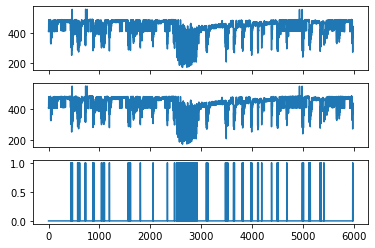

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(6, 4), sharex=True)
axes[0].plot(x.Tip2)
axes[1].plot(e.compute_placeholder(x))
axes[2].plot(e.evaluate(x))

In [17]:
realtime = Xcoords.from_hdf5(path_realtime)
posthoc  = Xcoords.from_hdf5(path_posthoc)
t = get_time(path_realtime)
px_per_mm = get_scale(path_posthoc)

ev = Evaluation.from_hdf5(path_realtime)
v_realtime = ev.compute_placeholder(realtime)
v_posthoc  = ev.compute_placeholder(posthoc)
diff = v_realtime - v_posthoc
trig_realtime = ev.evaluate(realtime)

In [18]:
def count_trigger(trigger):
    return np.count_nonzero(np.diff(trigger.astype(np.int64)) == 1)

In [19]:
count_trigger(trig_realtime)

135

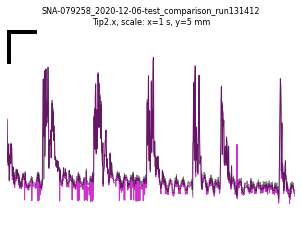

In [20]:
scale_x = 5
scale_t = 1
origin  = (39, 20)
name    = info.update(domain='comparison', suffix="").name

fig = plt.figure(figsize=(4, 3))
plt.plot(t, v_realtime/px_per_mm, lw=1, alpha=.8, c='m')
plt.plot(t, v_posthoc/px_per_mm, lw=1, alpha=.5, c='k')
plt.xlim(39, 49)
plt.ylim(20, 50)
plt.gca().add_patch(Rectangle(origin,0.09,scale_x, color="k"))
plt.gca().add_patch(Rectangle(origin,scale_t, 0.45, color="k"))
plt.title(f"{name}\nTip2.x, scale: x={scale_t} s, y={scale_x} mm", fontsize=8)
plt.gca().invert_yaxis()
plt.gca().set_axis_off()
plt.subplots_adjust(left=0, right=1, bottom=0, top=.9)

outdir = Path("F01_trace-comparison")
if not outdir.exists():
    outdir.mkdir(parents=True)
fig.savefig(str(outdir / f"{name}.png"), dpi=400)
fig.savefig(str(outdir / f"{name}.svg"))

In [21]:
diff.mean(), diff.std(ddof=1)

(-0.11203589353246307, 16.349442362552534)

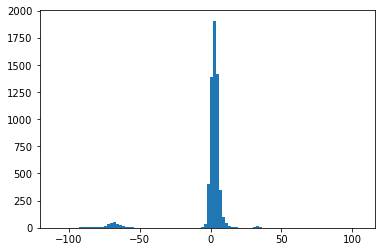

In [22]:
_ = plt.hist(diff, bins=100)

As the "base" data, the following arrays per session will be stored:

1. `realtime`, `posthoc`: point-to-point estimations of the real-time and the post-hoc values.
2. `trigger`: the trigger (evaluation) status during the real-time acquisition.

In addition, `attrs['expression']` will store the expression used to compute values (as in the `evaluation` section of the raw videos).
It would be also better having `attrs['px_per_mm']` (probably from the `posthoc` data).

## Calculation of conditional probability

Let $Q$ be the trigger status, where $Q=q$ indicates the trigger is ON, whereas $Q=\overline{q}$ representing the cases the trigger is OFF.

And let $V$ be the value to be evaluated (based on the body part estimations, e.g. `constant - {Tip2.x}` or `{Tip3.x} - {Tip1.x} - constant`). We can assume that the trigger is generated when $V > 0$ without losing generality.

The "accuracy" of real-time evaluation would be estimated by computing the conditional probability $P\left(Q=q \mid V=v\right)$. If the real-time accuracy is 100%, then it would turn out:

$$P\left(Q=q \mid V=v\right) = \begin{cases}
0 & (v <= 0) \\
1 & (v > 0)
\end{cases}$$

Otherwise the probability distribution of $P\left(Q=q \mid V=v\right)$ would have a sigmoid shape. Here we assume that the threshold of real-time evaluation can be represented as a Gaussian shape, i.e. a cumulative Gaussian distribution can be fitted to the distribution of $P\left(Q=q \mid V=v\right)$.

In [23]:
def calc_event_density(events, positions, std=3):
    """kernel-density normalization using a Gaussian kernel.
    
    parameters
    ----------
    events    -- the positions where trigger occurred.
    positions -- the series of positions on which the densities are computed.
    std       -- the standard deviation of the Gaussian kernel (in the metric of `positions`).
    """
    events    = events.reshape((-1,1))
    positions = positions.reshape((1,-1))
    values = sstats.norm.pdf( (events - positions)/std )
    return values.sum(0)

def valid_range(density, lower=3):
    """returns a slice object corresponding to the 'valid' range, i.e. the density is high enough,
    to make sense of the fitting."""
    supra = np.where(density > lower)[0]
    return slice(supra.min(), supra.max())


def sigmoid(sign=1):
    """the sigmoid curve, based on the cumulative function of a Gaussian distribution.
    
    if sign is 1, it generates the S-shaped curves. if sign is -1, it generates the Z-shaped curves.
    """
    if sign == 1:
        def _sigmoid(x, mean, std):
            return sstats.norm.cdf(x, loc=mean, scale=std)
    elif sign == -1:
        def _sigmoid(x, mean, std):
            return 1-sstats.norm.cdf(x, loc=mean, scale=std)
    else:
        raise ValueError(f"sign must be 1 or -1, got {sign}")
    return _sigmoid

def calc_conditional(density_all, density_triggered):
    siz = density_all.size
    pos = np.arange(siz)
    calced = density_all > 0
    p = np.interp(pos, pos[calced], density_triggered[calced] / density_all[calced])
    p[p > 1] = 1
    return p

In [24]:
positions = np.arange(0, 640*10)/10

In [25]:
density_all = calc_event_density(v_posthoc, positions, std=0.5*px_per_mm)
density_triggered = calc_event_density(v_posthoc[trig_realtime], positions, std=0.5*px_per_mm)
sign = ev.sign

Text(0.5, 1.0, 'sign=-1')

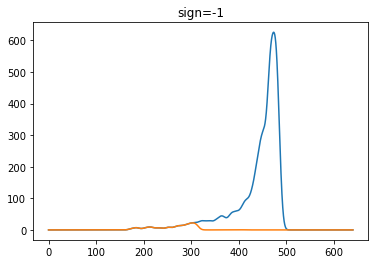

In [26]:
plt.plot(positions, density_all)
plt.plot(positions, density_triggered)
plt.title(f"sign={sign}")

In [27]:
valid = valid_range(density_all)
valid

slice(1707, 5003, None)

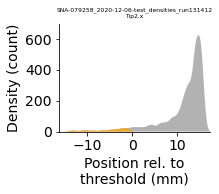

In [28]:
labelsize = 14
name    = info.update(domain='densities', suffix="").name

target_mm = ev.constant / px_per_mm
pos_mm = positions / px_per_mm - target_mm

fig = plt.figure(figsize=(3,2.5))
plt.fill_between(pos_mm, density_all,
                 color="gray", lw=0, alpha=.6)
plt.fill_between(pos_mm, density_triggered,
                 color="orange", lw=0, alpha=.8)
plt.xlim(150/px_per_mm - target_mm, 500/px_per_mm - target_mm)
plt.ylim(0, 700)
# plt.xticks((200, 300, 400))
plt.yticks((0, 200, 400, 600))
plt.title(f"{name}\nTip2.x", fontsize=6)
plt.xlabel("Position rel. to\nthreshold (mm)", fontsize=labelsize)
plt.ylabel("Density (count)", fontsize=labelsize)
plt.tick_params(labelsize=labelsize)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.subplots_adjust(bottom=.3, left=.25, right=.95, top=.9)

outdir = Path("F02_densities")
if not outdir.exists():
    outdir.mkdir(parents=True)
fig.savefig(str(outdir / f"{name}.png"), dpi=400)
fig.savefig(str(outdir / f"{name}.svg"))

In [29]:
vpos  = positions[valid]
vcond = calc_conditional(density_all[valid], density_triggered[valid])
vsig  = sigmoid(sign)

([<matplotlib.axis.YTick at 0x7f395d660250>,
 [Text(0, 0.0, '0'), Text(0, 0.5, '0.5'), Text(0, 1.0, '1')])

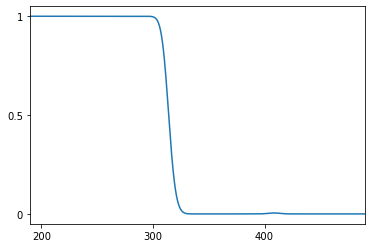

In [30]:
plt.plot(vpos, vcond)
plt.xlim(190, 490)
plt.ylim(-0.05, 1.05)
plt.xticks((200, 300, 400))
plt.yticks((0, 0.5, 1), ("0", "0.5", "1"))

In [31]:
opt, cov = curve_fit(vsig, vpos, vcond, p0=(ev.constant, 1))

In [32]:
mean, std = opt

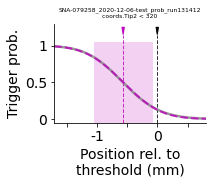

In [33]:
labelsize = 14
name    = info.update(domain='prob', suffix="").name
arrowbase   = 1.15
arrowheight = 0.1
arrowwidth  = 0.02

color      = "m"
vpos_mm    = vpos / px_per_mm
target_mm  = ev.constant / px_per_mm
mean_mm    = mean / px_per_mm
delta_mm   = mean_mm - target_mm
std_mm     = std / px_per_mm

fig = plt.figure(figsize=(3,2.5))
plt.plot(vpos_mm - target_mm, vcond, "-", lw=2.5, c="gray", alpha=.8)
plt.plot(vpos_mm - target_mm, vsig(vpos, mean, std), "--", c=color, lw=2, alpha=.8)

for pos, col in ((0, "k"), (delta_mm, color)):
    plt.vlines(pos, -0.05, arrowbase, linewidth=1, linestyle="dashed", color=col, alpha=.8)
    plt.gca().add_patch(Polygon(((pos-arrowwidth, arrowbase + arrowheight),
                                 (pos, arrowbase),
                                 (pos + arrowwidth, arrowbase + arrowheight)),
                                color=col))
plt.fill_betweenx((-0.05, 1.05), delta_mm - std_mm, delta_mm + std_mm,
                  lw=0, color=color, alpha=.18)
plt.xlim(-1.7, 0.8)
plt.ylim(-0.05, 1.3)
plt.xticks((-1.5, -1, -0.5, 0, 0.5), ("", "-1", "", "0", ""))
plt.yticks((0, 0.5, 1), ("0", "0.5", "1"))
plt.title(f"{name}\n{ev.expression}", fontsize=6)
plt.xlabel("Position rel. to\nthreshold (mm)", fontsize=labelsize)
plt.ylabel("Trigger prob.", fontsize=labelsize)
plt.tick_params(labelsize=labelsize)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.subplots_adjust(bottom=.35, left=.25, right=.95, top=.9)

outpath = Path("F03_conditional-probability")
if not outpath.exists():
    outpath.mkdir(parents=True)
fig.savefig(str(outpath / f"{name}.png"), dpi=400)
fig.savefig(str(outpath / f"{name}.svg"))

## Checking with the spread condition

In [34]:
sub  = "SNA-079258"
sess = "2020-12-06-test"
run  = "132135"

In [35]:
path_posthoc  = sorted(p for p in (root_posthoc / sub / sess).glob(f"*_run{run}.h5"))[0]
info = RunInfo.from_path(path_posthoc)
path_realtime = info.update(domain="video").to_path(root=root_realtime)
assert(path_realtime.exists())

realtime = Xcoords.from_hdf5(path_realtime)
posthoc  = Xcoords.from_hdf5(path_posthoc)
t = get_time(path_realtime)
px_per_mm = get_scale(path_posthoc)

ev = Evaluation.from_hdf5(path_realtime)
print(f"expression: {repr(ev.expression)}")
v_realtime = ev.compute_placeholder(realtime)
v_posthoc  = ev.compute_placeholder(posthoc)
diff = v_realtime - v_posthoc
trig_realtime = ev.evaluate(realtime)

expression: 'coords.Tip3 - coords.Tip1 > 150'


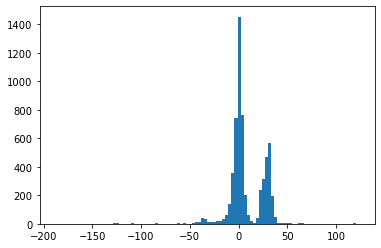

In [36]:
_ = plt.hist(diff, bins=100)

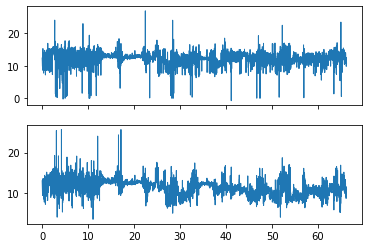

In [37]:
fig, axes = plt.subplots(2,1,sharex=True)
axes[0].plot(t, v_realtime/px_per_mm, lw=1)
axes[1].plot(t, v_posthoc/px_per_mm, lw=1)
# plt.xlim(20, 30)

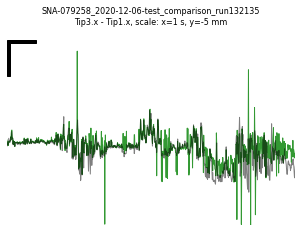

In [38]:
scale_x = -5
scale_t = 1
origin  = (20, 28)
name    = info.update(domain='comparison', suffix="").name

fig = plt.figure(figsize=(4, 3))
plt.plot(t, v_realtime/px_per_mm, lw=1, alpha=.8, c='g')
plt.plot(t, v_posthoc/px_per_mm, lw=1, alpha=.5, c='k')
plt.xlim(20, 30)
plt.ylim(0, 30)
plt.gca().add_patch(Rectangle(origin,0.09,scale_x, color="k"))
plt.gca().add_patch(Rectangle(origin,scale_t, 0.45, color="k"))
plt.title(f"{name}\nTip3.x - Tip1.x, scale: x={scale_t} s, y={scale_x} mm", fontsize=8)

plt.gca().set_axis_off()
plt.subplots_adjust(left=0, right=1, bottom=0, top=.9)

outdir = Path("F01_trace-comparison")
if not outdir.exists():
    outdir.mkdir(parents=True)
fig.savefig(str(outdir / f"{name}.png"), dpi=400)
fig.savefig(str(outdir / f"{name}.svg"))

In [39]:
density_all = calc_event_density(v_posthoc, positions, std=0.5*px_per_mm)
density_triggered = calc_event_density(v_posthoc[trig_realtime], positions, std=0.5*px_per_mm)
sign = ev.sign

Text(0.5, 1.0, 'sign=1')

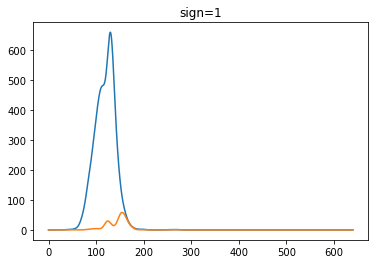

In [40]:
plt.plot(positions, density_all)
plt.plot(positions, density_triggered)
plt.title(f"sign={sign}")

In [41]:
valid = valid_range(density_all)
vpos  = positions[valid]
vcond = calc_conditional(density_all[valid], density_triggered[valid])
vsig  = sigmoid(sign)

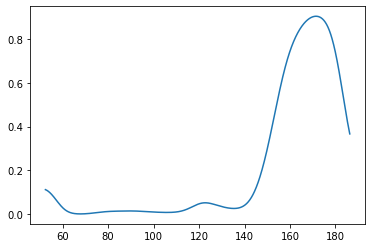

In [42]:
plt.plot(vpos, vcond)

In [43]:
opt, cov = curve_fit(vsig, vpos, vcond, p0=(ev.constant, 1))
mean, std = opt

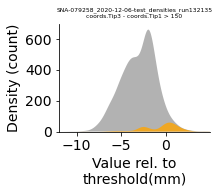

In [44]:
labelsize = 14
name    = info.update(domain='densities', suffix="").name

target_mm = ev.constant / px_per_mm
pos_mm    = (positions - ev.constant) / px_per_mm

fig = plt.figure(figsize=(3,2.5))
plt.fill_between(pos_mm, density_all,
                 color="gray", lw=0, alpha=.6)
plt.fill_between(pos_mm, density_triggered,
                 color="orange", lw=0, alpha=.8)
plt.xlim(-12, 5)
plt.ylim(0, 700)
plt.xticks((-10, -5, 0))
plt.yticks((0, 200, 400, 600))
plt.title(f"{name}\n{ev.expression}", fontsize=6)
plt.xlabel("Value rel. to\nthreshold(mm)", fontsize=labelsize)
plt.ylabel("Density (count)", fontsize=labelsize)
plt.tick_params(labelsize=labelsize)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.subplots_adjust(bottom=.3, left=.25, right=.95, top=.9)

outdir = Path("F02_densities")
if not outdir.exists():
    outdir.mkdir(parents=True)
fig.savefig(str(outdir / f"{name}.png"), dpi=400)
fig.savefig(str(outdir / f"{name}.svg"))

target=14.42, mean=14.90, std=1.02


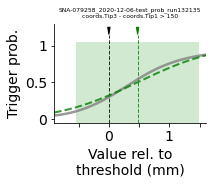

In [45]:
labelsize = 14
name    = info.update(domain='prob', suffix="").name
arrowbase   = 1.15
arrowheight = 0.1
arrowwidth  = 0.02

color      = "g"
target_mm  = ev.constant / px_per_mm
vpos_mm    = (vpos / px_per_mm) - target_mm
mean_mm    = (mean / px_per_mm) - target_mm
std_mm     = std / px_per_mm

fig = plt.figure(figsize=(3,2.5))
plt.plot(vpos_mm, vcond, "-", lw=2.5, c="gray", alpha=.8)
plt.plot(vpos_mm, vsig(vpos, mean, std), "--", c=color, lw=2, alpha=.8)

for pos, col in ((0, "k"), (mean_mm, color)):
    plt.vlines(pos, -0.05, arrowbase, linewidth=1, linestyle="dashed", color=col, alpha=.8)
    plt.gca().add_patch(Polygon(((pos-arrowwidth, arrowbase + arrowheight),
                                 (pos, arrowbase),
                                 (pos + arrowwidth, arrowbase + arrowheight)),
                                color=col))
plt.fill_betweenx((-0.05, 1.05), mean_mm - std_mm, mean_mm + std_mm,
                  lw=0, color=color, alpha=.18)
plt.xlim(-0.9, 1.6)
plt.ylim(-0.05, 1.3)
plt.xticks((-0.5, 0, 0.5, 1, 1.5), ("", "0", "", "1", ""))
plt.yticks((0, 0.5, 1), ("0", "0.5", "1"))
plt.title(f"{name}\n{ev.expression}", fontsize=6)
plt.xlabel("Value rel. to\nthreshold (mm)", fontsize=labelsize)
plt.ylabel("Trigger prob.", fontsize=labelsize)
plt.tick_params(labelsize=labelsize)
for side in ("top", "right"):
    plt.gca().spines[side].set_visible(False)
plt.subplots_adjust(bottom=.35, left=.25, right=.95, top=.9)

outpath = Path("F03_conditional-probability")
if not outpath.exists():
    outpath.mkdir(parents=True)
fig.savefig(str(outpath / f"{name}.png"), dpi=400)
fig.savefig(str(outpath / f"{name}.svg"))
print(f"target={ev.constant/px_per_mm:.2f}, mean={mean/px_per_mm:.2f}, std={std/px_per_mm:.2f}")

The `density` field will contain the event-density information, including:

1. `density/positions` -- evenly-spaced position-value parameter (both "valid" and the other ranges).
2. `density/all` -- the density of all the position-values (based on the post-hoc estimation)
3. `density/triggered` -- the density of the position-values when the trigger was ON.
4. `density/kernel` -- the info of the Gaussian kernel in `attrs`:
  - `type=Gaussian`
  - `std=<std>`

The `conditional` field will contain the conditional probability information, including:

1. `conditional/values` -- the "valid" values used in calculation.
2. `conditional/probability` -- the probability distribution.
3. `conditional.attrs` -- info of the fitted sigmoid curve:
  - `sigmoid_sign=<sign>`
  - `sigmoid_mean=<mean>`
  - `sigmoid_std=<std>`

# Batch processing

In [46]:
class BaseData(namedtuple("_Base", ("time", "realtime", "posthoc", "evaluation", "trigger", "px_per_mm"))):
    """a class responsible for storage of 'values' and 'trigger' entries."""
    @classmethod
    def from_paths(cls, path_realtime, path_posthoc, min_event_count=20):
        realtime = Xcoords.from_hdf5(path_realtime)
        posthoc  = Xcoords.from_hdf5(path_posthoc)
        t = get_time(path_realtime)
        scale = get_scale(path_posthoc)

        ev = Evaluation.from_hdf5(path_realtime)
        trig       = ev.evaluate(realtime)
        ntrig      = count_trigger(trig)
        if ntrig < min_event_count:
            raise RuntimeError(f"too small event number ({ntrig})")
        return cls(t, realtime, posthoc, ev, trig, scale)
    
    def write_hdf5(self, parent, compression=5, jump_threshold_mm=10):
        opts = dict(compression=compression)
        
        parent.attrs["px_per_mm"] = self.px_per_mm
        
        # raw pose data
        root = parent.create_group("pose")
        root.attrs["description"] = "point-to-point comparison of the real-time and the post-hoc body-part estimation data."
        root.attrs["px_per_mm"]   = self.px_per_mm
        
        time = root.create_dataset("time", data=self.time, **opts)
        time.attrs["description"] = "the time base of the series values, based on the timestamp field of the video"
        time.attrs["unit"] = "s"
        
        for adj, val in (("real-time", self.realtime),
                         ("post-hoc", self.posthoc)):
            lab  = adj.replace("-", "")
            group = root.create_group(lab)
            group.attrs["description"] = f"the {adj} body-part estimation."
            group.attrs["px_per_mm"]   = self.px_per_mm
            
            for attr in val._fields:
                data = group.create_dataset(attr, data=getattr(val, attr), **opts)
                data.attrs["description"] = f"the {adj} estimation of {attr} (x-coordinates)."
                data.attrs["unit"] = "px"
                data.attrs["px_per_mm"] = self.px_per_mm
        
        # jump frequency data
        jump = root["realtime"].create_group("jump")
        jump.attrs["description"] = "the frequency of 'jump' events in real-time pose estimation."
        jump.attrs["threshold_mm"] = jump_threshold_mm
        jump.attrs["unit"] = "count/count"
        
        threshold_px = jump_threshold_mm / self.px_per_mm
        for attr in self.realtime._fields:
            data = getattr(self.realtime, attr)
            diff = np.abs(np.diff(data))
            jump_freq = np.count_nonzero(diff > threshold_px) / diff.size
            jump.attrs[attr] = jump_freq        
        
        # evaluation data
        root = parent.create_group("evaluation")
        root.attrs["description"] = "the time-series evaluation data where the event densities were computed from."
        root.attrs["px_per_mm"]   = self.px_per_mm
        
        time = root.create_dataset("time", data=self.time, **opts)
        time.attrs["description"] = "the time base of the series values, based on the timestamp field of the video"
        time.attrs["unit"] = "s"
        for adj, val in (("real-time", self.evaluation.compute_placeholder(self.realtime)),
                         ("post-hoc", self.evaluation.compute_placeholder(self.posthoc))):
            lab  = adj.replace("-", "")
            data = root.create_dataset(lab, data=val, **opts)
            data.attrs["description"] = f"the 'left-hand side' values, from which evaluation is performed, based on the {adj} estimation."
            data.attrs["unit"] = "px"
            data.attrs["px_per_mm"] = self.px_per_mm
        
        trigger = root.create_dataset("trigger", data=self.trigger, **opts)
        trigger.attrs["description"] = "the status of pose-trigger during the real-time acquisition."
        
        for entry in (root, trigger):
            entry.attrs["expression"] = self.evaluation.expression

class Densities(namedtuple("_Densities", ("positions", "std", "all", "triggered"))):
    """a class responsible for calculation and storage of the 'densities' entry."""
    @classmethod
    def from_basedata(cls, basedata, positions=None, std_mm=0.5):
        if positions is None:
            positions = np.arange(-100, 640*10)/10
        std = std_mm * basedata.px_per_mm
        values            = basedata.evaluation.compute_placeholder(basedata.posthoc)
        density_all       = calc_event_density(values, positions, std=std)
        density_triggered = calc_event_density(values[basedata.trigger], positions, std=std)
        return cls(positions, std,
                   density_all, density_triggered)
    
    def write_hdf5(self, parent, compression=5):
        opts = dict(compression=compression)
        root = parent.create_group("densities")
        root.attrs["description"] = "kernel-density estimation of the base position-value data."
        
        pos   = root.create_dataset("positions", data=self.positions, **opts)
        pos.attrs["description"] = "the position-values where densities were computed using kernel-density estimation."
        pos.attrs["unit"] = "px"
        d_all = root.create_dataset("all", data=self.all, **opts)
        d_all.attrs["description"] = "the estimated density for position-values during the whole acquisition, based on the post-hoc estimations."
        d_all.attrs["unit"] = "count"
        d_trig = root.create_dataset("triggered", data=self.triggered, **opts)
        d_trig.attrs["description"] = "the estimated density for position-values when the real-time trigger was ON."
        
        kernel = root.create_group("kernel")
        kernel.attrs["description"] = "the information of the kernel used for density estimation."
        kernel.attrs["type"] = "Gaussian"
        kernel.attrs["std"]  = self.std

class Probability(namedtuple("_Prob", ("positions", "values", "target", "cutoff", "sigmoid"))):
    """a class responsible for calculation and storage of the conditional probability."""
    @classmethod
    def from_densities(cls, densities, sign=0, cutoff=3, target=100):
        valid = valid_range(densities.all, lower=cutoff)
        vpos  = densities.positions[valid]
        vcond = calc_conditional(densities.all[valid], densities.triggered[valid])
        vsig  = sigmoid(sign)
        opt, cov  = curve_fit(vsig, vpos, vcond, p0=(target, 1))
        mean, std = opt
        return cls(vpos, vcond, target, cutoff, dict(sign=sign, mean=mean, std=std))
    
    def write_hdf5(self, parent, compression=5):
        opts = dict(compression=compression)
        root = parent.create_group("conditional")
        root.attrs["description"] = "conditional probability of the real-time trigger at the given post-hoc position-values."
        root.attrs["original_target_position_px"] = self.target
        root.attrs["cutoff_density_count"] = self.cutoff
        
        pos = root.create_dataset("positions", data=self.positions, **opts)
        pos.attrs["description"] = "the position-value axis of the conditional probability."
        pos.attrs["unit"] = "px"
        val = root.create_dataset("probability", data=self.values, **opts)
        val.attrs["description"] = "the conditional probability at the given position-value."
        val.attrs["unit"] = ""
        sig = root.create_group("sigmoid")
        sig.attrs["description"] = "the results of the sigmoid fitting to the conditional probability distribution."
        for k, v in self.sigmoid.items():
            sig.attrs[k] = v

class VideoAnalysis(namedtuple("_Video", ("info", "basedata", "densities", "probability"))):
    """a class representing the analysis of a single video."""
    @classmethod
    def from_posthoc(cls, path_posthoc, root_realtime=root_realtime,
                     positions=None, min_event_count=30,
                     density_kernel_std_mm=0.5, density_cutoff=3):
        info = RunInfo.from_path(path_posthoc).update(domain="analysis")
        path_realtime = info.update(domain="video").to_path(root=root_realtime)
        base = BaseData.from_paths(path_realtime, path_posthoc, min_event_count=min_event_count)
        dens = Densities.from_basedata(base, positions=positions, std_mm=density_kernel_std_mm)
        prob = Probability.from_densities(dens, sign=base.evaluation.sign,
                                          cutoff=density_cutoff, target=base.evaluation.constant)
        return cls(info, base, dens, prob)
    
    def write_hdf5(self, name, parent, compression=5, verbose=True):
        if verbose == True:
            print(f"{name}: {self.info.subject}/{self.info.session}/run{self.info.run}...", end=" ", flush=True)
        entry = parent.create_group(name)
        entry.attrs["subject"] = self.info.subject
        entry.attrs["session"] = self.info.session
        entry.attrs["run"]     = self.info.run
        entry.attrs["expression"] = self.basedata.evaluation.expression
        for sub in (self.basedata, self.densities, self.probability):
            sub.write_hdf5(entry, compression=compression)
        if verbose == True:
            print("done (expr='{expr}', sign={sign}).".format(expr=self.basedata.evaluation.expression,
                                                            sign=self.probability.sigmoid["sign"]), flush=True)

In [47]:
index = 1
positions = np.arange(-1000, 6400)/10

with h5py.File("analyzed-data.h5", "w") as out:
    for subdir in sorted(root_posthoc.iterdir()):
        if not subdir.is_dir():
            continue
        for sessdir in sorted(subdir.glob("2020-*")):
            if not sessdir.is_dir():
                continue
            for path_posthoc in sorted(sessdir.glob("*.h5")):
                try:
                    data = VideoAnalysis.from_posthoc(path_posthoc,
                                                      root_realtime=root_realtime,
                                                      positions=positions)
                    data.write_hdf5(str(index).zfill(3), out, verbose=True)
                    index += 1
                except RuntimeError as e:
                    print(f"***{path_posthoc.stem.replace('_', '/')}: {e}", flush=True)
print(f"done {index-1} videos.")

001: MLA-041630/2020-09-11-test/run151428... done (expr='coords.Tip2 < 300', sign=-1).
002: MLA-041630/2020-09-11-test/run151508... done (expr='coords.Tip2 < 300', sign=-1).
003: MLA-041630/2020-09-11-test/run151803... done (expr='coords.Tip3 - coords.Tip1 > 200', sign=1).
004: MLA-041630/2020-09-11-test/run151850... done (expr='coords.Tip3 - coords.Tip1 > 200', sign=1).
005: MLA-041630/2020-09-11-test/run151932... done (expr='coords.Tip3 - coords.Tip1 > 200', sign=1).
006: S005-19/2020-09-11-test/run141942... done (expr='coords.Tip2 < 250', sign=-1).
007: S005-19/2020-09-11-test/run142512... done (expr='coords.Tip3 - coords.Tip1 > 200', sign=1).
008: S006-19/2020-09-11-test/run150832... done (expr='coords.Tip3 - coords.Tip1 > 200', sign=1).
009: S006-19/2020-09-11-test/run150918... done (expr='coords.Tip3 - coords.Tip1 > 80', sign=1).
010: S006-19/2020-09-11-test/run151019... done (expr='coords.Tip2 < 300', sign=-1).
011: SNA-079258/2020-12-06-test/run131412... done (expr='coords.Tip2